<a href="https://colab.research.google.com/github/phraretein/flight_delay_prediction/blob/master/mlp_classification_smote_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN - MLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pickle5

     |████████████████████████████████| 133kB 5.8MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp37-cp37m-linux_x86_64.whl size=219244 sha256=66f97807504f2fad90e2e4e7fb92359c56513ec219e375e5681fa26234933cdf
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [3]:
import pandas as pd
import numpy as np
import pickle5 as pickle

In [4]:
# Retrieve data
df = pickle.load(open(r'/content/drive/My Drive/Senior Project/df_train_update.pkl', "rb"))
df_test = pickle.load(open(r'/content/drive/My Drive/Senior Project/df_test_update.pkl', "rb"))

In [5]:
# One-hot encoding
encode_columns = ['OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST']
df_encoded = pd.get_dummies(df, columns=encode_columns)
df_test_encoded = pd.get_dummies(df_test, columns=encode_columns)
# df_encoded.info(memory_usage='deep')
del df, df_test

In [6]:
# y and X
y = df_encoded[['DEP_DELAY_GROUP']].copy()
X = df_encoded.drop(['DEP_DELAY_GROUP'], axis=1).copy()
y_test = df_test_encoded[['DEP_DELAY_GROUP']].copy()
X_test = df_test_encoded.drop(['DEP_DELAY_GROUP'], axis=1).copy()
del df_encoded
del df_test_encoded

In [7]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
X_scaled = X.copy()
scale_column = ['YEAR', 'MONTH', 'DAY_OF_MONTH', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
features = X_scaled[scale_column]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
X_scaled[scale_column] = features

X_test_scaled = X_test.copy()
test_features = X_test_scaled[scale_column]
test_scaler = MinMaxScaler().fit(test_features.values)
test_features = test_scaler.transform(test_features.values)
X_test_scaled[scale_column] = test_features
del features
del scaler

In [8]:
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [9]:
# Oversample
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

In [10]:
tf.compat.v1.enable_eager_execution()

In [11]:
# One-hot encoded y
y_train_df_encoded = pd.get_dummies(y_resampled, columns=['DEP_DELAY_GROUP'])
y_train_encoded = y_train_df_encoded.to_numpy()
del y_train_df_encoded 

y_test_df_encoded = pd.get_dummies(y_test, columns=['DEP_DELAY_GROUP'])
y_test_encoded = y_test_df_encoded.to_numpy()
del y_test_df_encoded 

In [ ]:
# Calculate class weight
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_train_encoded, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [27]:
def baseline_model(X):
    # alpha = 10
    # n_h = X.shape[0] / (alpha * (37 + 3))
    # n_h = int((2 * 37) + 1)
    # n_h = int(((2/3) * 37) + 3)
    # Create model here
    model = Sequential()
    model.add(Dense(37, input_dim = X.shape[1], activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
    model.add(Dense(64, activation = 'relu', name='hidden_1'))
    model.add(Dense(16, activation = 'relu', name='hidden_2'))
    model.add(Dense(8, activation = 'relu', name='hidden_3'))
    # model.add(Dense(99, activation = 'relu', name='hidden_3'))
    model.add(Dense(3, activation = 'softmax', name='output_layer')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    return model

In [28]:
baseline_model = baseline_model(X_scaled)

In [38]:
history = baseline_model.fit(X_resampled, 
                        y_train_encoded, 
                        batch_size=128, 
                        epochs=20, 
                        verbose=1, 
                        # class_weight = d_class_weights, 
                        validation_data=(X_test_scaled, y_test_encoded))

Epoch 1/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.9051 - accuracy: 0.5632 - val_loss: 0.9721 - val_accuracy: 0.5000
Epoch 2/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.9034 - accuracy: 0.5645 - val_loss: 0.9962 - val_accuracy: 0.4947
Epoch 3/20
10227/10227 [==============================] - 38s 4ms/step - loss: 0.9027 - accuracy: 0.5647 - val_loss: 0.9748 - val_accuracy: 0.5081
Epoch 4/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.9019 - accuracy: 0.5651 - val_loss: 0.9610 - val_accuracy: 0.5146
Epoch 5/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.9013 - accuracy: 0.5652 - val_loss: 0.9728 - val_accuracy: 0.5041
Epoch 6/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.9003 - accuracy: 0.5657 - val_loss: 0.9928 - val_accuracy: 0.4893
Epoch 7/20
10227/10227 [==============================] - 37s 4ms/step - loss: 0.8998 - accuracy: 0.5660 - val_loss: 0

In [17]:
import matplotlib.pyplot as plt

In [39]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


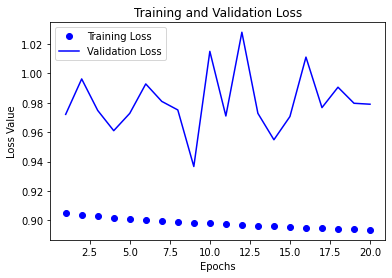

In [40]:
# Plotting losses
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss")

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()

plt.show()

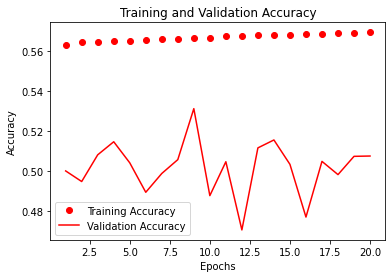

In [41]:
# Training and Validation Accuracy

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, acc_values, 'ro', label="Training Accuracy")
plt.plot(epochs, val_acc_values, 'r-', label="Validation Accuracy")

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [21]:
from sklearn.metrics import classification_report

y_pred = baseline_model.predict(X_test_scaled, batch_size=512, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

1041/1041 [==============================] - 1s 1ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.53      0.66    430538
         1.0       0.24      0.34      0.28     90587
         2.0       0.03      0.38      0.06     11381

    accuracy                           0.49    532506
   macro avg       0.38      0.41      0.33    532506
weighted avg       0.74      0.49      0.58    532506



In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_bool)
print("Accuracy using train sample: {:.4}%".format(accuracy * 100))

Accuracy using train sample: 49.3%


# Focal Loss

In [ ]:
from keras import backend as K
import tensorflow as tf

def focal_loss_model(X, y_train, y_pred):
    alpha = 10
    n_h = X.shape[0] / (alpha * (37 + 3))


    def focal_loss(gamma=2.0, alpha=0.25):
      gamma = float(gamma)
      alpha = float(alpha)
      def focal_loss_fixed(y_true, y_pred):
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
      return focal_loss_fixed


    # Create model here
    model = Sequential()
    model.add(Dense(25, input_dim = X.shape[1], activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
    model.add(Dense(n_h, activation = 'relu', name='hidden_1'))
    # model.add(Dense(198, activation = 'relu', name='hidden_2'))
    # model.add(Dense(99, activation = 'relu', name='hidden_3'))
    model.add(Dense(3, activation = 'softmax', name='output_layer')) # Softmax for multi-class classification
    # Compile model here
    model.compile(loss = focal_loss(alpha=1), optimizer = 'adam', metrics=['accuracy'])

    model.fit(X, y_train, epochs=80, batch_size=1028, verbose=1)
    return model

In [ ]:
model_f = Sequential()
model_f.add(Dense(25, input_dim = 37, activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
n_h = X.shape[0] / (8 * (37 + 3))
model_f.add(Dense(n_h, activation = 'relu', name='hidden_1'))
model_f.add(Dense(3, activation = 'softmax', name='output_layer'))

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
  gamma = float(gamma)
  alpha = float(alpha)
  def focal_loss_fixed(y_true, y_pred):
    epsilon = 1.e-9
    y_true = tf.convert_to_tensor(y_true, tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, tf.float32)

    model_out = tf.add(y_pred, epsilon)
    ce = tf.multiply(y_true, -tf.log(model_out))
    weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
    fl = tf.multiply(alpha, tf.multiply(weight, ce))
    reduced_fl = tf.reduce_max(fl, axis=1)
    return tf.reduce_mean(reduced_fl)
  return focal_loss_fixed

In [ ]:
model_f.compile(loss=focal_loss(alpha=1), optimizer='adam', metrics=['accuracy'])

In [ ]:
model_f.fit(X_scaled, y_train_encoded, epochs=3, batch_size=1028)

Epoch 1/3


ValueError: ignored

In [ ]:
focal_loss_model = focal_loss_model(X_scaled, y_train_encoded)

TypeError: ignored

In [ ]:
focal_history = focal_loss_model.fit(X_scaled, 
                        y_train_encoded, 
                        batch_size=1028, 
                        epochs=80, 
                        verbose=1)

Epoch 1/80


ValueError: ignored

# Optuna

In [ ]:
!pip install optuna

     |████████████████████████████████| 296kB 13.7MB/s 
     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 163kB 29.9MB/s 
     |████████████████████████████████| 143kB 28.4MB/s 
     |████████████████████████████████| 112kB 32.6MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=e12970108620d013d45f8e0a20b70e07dd0f987c0b6da5fa9a19ebca7f8a8ae6
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
# Optuna
import sklearn.metrics
import optuna
from sklearn.metrics import accuracy_score

def opt(X_train, y_train, X_test, y_test, class_weights, trial):
  # print(y_train)
  # print(y_test)
  # print(class_weights)
  # print(X.shape[0])
  # print(X.shape[1])
  # print(y.shape[1])
  # clear_session()
  # One-hot encoded y
  y_train_df_encoded = pd.get_dummies(y_train, columns=['DEP_DELAY_GROUP'])
  y_train_encoded = y_train_df_encoded.to_numpy()
  del y_train_df_encoded 

  y_test_df_encoded = pd.get_dummies(y_test, columns=['DEP_DELAY_GROUP'])
  y_test_encoded = y_test_df_encoded.to_numpy()
  del y_test_df_encoded 
  
  # parameters
  alpha = trial.suggest_discrete_uniform('alpha', 2, 10, 1)
  input_layer = X.shape[1]
  # n_h = int(X.shape[0] / (alpha * (input_layer + y.shape[1])))
  n_h = trial.suggest_int('n_hidden_layer', 10, 20)
  batch_val = [32, 64, 128, 256]
  batch_size = batch_val[int(trial.suggest_discrete_uniform('batch_index', 0, 3, 1))]
  # epochs_val = [100, 200]
  # epochs = epochs_val[int(trial.suggest_discrete_uniform('epochs', 0, 1, 1))]
  epochs = trial.suggest_int('epochs', 50, 100)
  # print(batch_size)
  # print(n_h)
  # Create model 
  model = Sequential()
  model.add(Dense(input_layer, input_dim = X.shape[1], activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
  model.add(Dense(n_h, activation = 'relu', name='hidden_1'))
  model.add(Dense(3, activation = 'softmax', name='output_layer')) # Softmax for multi-class classification
  # Compile model 
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  model.fit(X_train, 
            y_train_encoded, 
            batch_size=batch_size, 
            epochs=epochs, 
            verbose=1, 
            class_weight=class_weights)
  pred_test = model.predict(X_test)
  y_pred_bool = np.argmax(pred_test, axis=1)

  return (1.0 - accuracy_score(y_test, y_pred_bool))

In [ ]:
import functools

study = optuna.create_study()
study.optimize(functools.partial(opt, X_scaled, y, X_test_scaled, y_test, d_class_weights), n_trials=25, show_progress_bar=True)

16287/16950 [===========================>..] - ETA: 1s - loss: 1.0071 - accuracy: 0.5196


KeyboardInterrupt: ignored

In [ ]:
# Best Param List
print(study.best_params)

{'alpha': 8.0, 'batch_index': 0.0, 'epochs': 80}


In [ ]:
import joblib

In [ ]:
filename = r'/content/drive/My Drive/Senior Project/study.pkl'
joblib.dump(study, open(filename, 'wb'))
print("Study Saved Successfully")

Study Saved Successfully


## Load Optuna Study Model

In [ ]:
import os

In [ ]:
if os.path.exists(r'/content/drive/My Drive/Senior Project/study.pkl'):
    study =  joblib.load(open(r'/content/drive/My Drive/Senior Project/study.pkl', 'rb'))

In [ ]:
print(study)

In [ ]:
# Plot Parameter Importance Graph
from optuna.visualization import plot_param_importances
fig = plot_param_importances(study)
fig.show()
# fig.write_image(r'/content/drive/My Drive/Senior Project/Hyperparameter Importance.png')

In [ ]:
# Plot Optimization History
fig = optuna.visualization.plot_optimization_history(study)
fig.show()
# fig.write_image(r'/content/drive/My Drive/Senior Project/Optimization History Plot.png')

In [ ]:
def opt_model(X, alpha):
  # parameters
  alpha = alpha
  input_layer = X.shape[1]
  n_h = int(X.shape[0] / (alpha * (input_layer + y.shape[1])))
  # batch_val = [32, 64, 128, 256]
  # batch_size = batch_val[batch_index]
  # epochs_val = [100, 200]
  # epochs = epochs_val[int(trial.suggest_discrete_uniform('epochs', 0, 1, 1))]
  # epochs = epochs
  # print(batch_size)
  # print(n_h)
  # Create model 
  model = Sequential()
  model.add(Dense(input_layer, input_dim = X.shape[1], activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
  model.add(Dense(n_h, activation = 'relu', name='hidden_1'))
  model.add(Dense(3, activation = 'softmax', name='output_layer')) # Softmax for multi-class classification
  # Compile model 
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  # model.fit(X_train, 
  #           y_train_encoded, 
  #           batch_size=batch_size, 
  #           epochs=epochs, 
  #           verbose=1, 
  #           class_weight=class_weights)
  return model

In [ ]:
opt_alpha = study.best_params['alpha']
opt_batch_index = int(study.best_params['batch_index'])
opt_epochs = study.best_params['epochs']

In [ ]:
opt_epochs

80

In [ ]:
clf = opt_model(X_scaled, opt_alpha)

In [ ]:
batch_val = [32, 64, 128, 256]
opt_batch_size = batch_val[opt_batch_index]

In [ ]:
history = clf.fit(X_scaled, 
                  y_train_encoded, 
                  batch_size=opt_batch_size, 
                  epochs=opt_epochs, 
                  verbose=1, 
                  class_weight = d_class_weights, 
                  validation_data=(X_test_scaled, y_test_encoded))

Epoch 1/80
16950/16950 [==============================] - 62s 4ms/step - loss: 1.0542 - accuracy: 0.4999 - val_loss: 1.0502 - val_accuracy: 0.4858
Epoch 2/80
16950/16950 [==============================] - 63s 4ms/step - loss: 1.0429 - accuracy: 0.5071 - val_loss: 1.0394 - val_accuracy: 0.5085
Epoch 3/80
16950/16950 [==============================] - 64s 4ms/step - loss: 1.0359 - accuracy: 0.5118 - val_loss: 1.0254 - val_accuracy: 0.5228
Epoch 4/80
16950/16950 [==============================] - 64s 4ms/step - loss: 1.0331 - accuracy: 0.5212 - val_loss: 1.0144 - val_accuracy: 0.5118
Epoch 5/80
16950/16950 [==============================] - 64s 4ms/step - loss: 1.0344 - accuracy: 0.5163 - val_loss: 1.0338 - val_accuracy: 0.5238
Epoch 6/80
16950/16950 [==============================] - 63s 4ms/step - loss: 1.0314 - accuracy: 0.5229 - val_loss: 1.0281 - val_accuracy: 0.5232
Epoch 7/80
16950/16950 [==============================] - 63s 4ms/step - loss: 1.0248 - accuracy: 0.5256 - val_loss: 1

In [ ]:
from sklearn.metrics import classification_report

y_pred_opt = clf.predict(X_test_scaled, batch_size=opt_batch_size, verbose=1)
y_pred_opt_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_opt_bool))

16641/16641 [==============================] - 15s 905us/step
              precision    recall  f1-score   support

         0.0       0.86      0.51      0.64    430538
         1.0       0.23      0.35      0.28     90587
         2.0       0.03      0.40      0.06     11381

    accuracy                           0.48    532506
   macro avg       0.38      0.42      0.33    532506
weighted avg       0.74      0.48      0.56    532506



In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_opt_bool)
print("Accuracy using train sample: {:.4}%".format(accuracy * 100))

Accuracy using train sample: 47.67%


In [ ]:
def opt_model_new(X_train, y_train_encoded, alpha, batch_size, epochs, class_weights):
  # parameters
  alpha = alpha
  input_layer = X.shape[1]
  n_h = int(X.shape[0] / (alpha * (input_layer + y.shape[1])))
  # batch_val = [32, 64, 128, 256]
  # batch_size = batch_val[batch_index]
  # epochs_val = [100, 200]
  # epochs = epochs_val[int(trial.suggest_discrete_uniform('epochs', 0, 1, 1))]
  # epochs = epochs
  # print(batch_size)
  # print(n_h)
  # Create model 
  model = Sequential()
  model.add(Dense(input_layer, input_dim = X.shape[1], activation = 'relu', name='input_layer')) # Rectified Linear Unit Activation Function
  model.add(Dense(n_h, activation = 'relu', name='hidden_1'))
  model.add(Dense(3, activation = 'softmax', name='output_layer')) # Softmax for multi-class classification
  # Compile model 
  model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

  model.fit(X_train, 
            y_train_encoded, 
            batch_size=batch_size, 
            epochs=epochs, 
            verbose=1, 
            class_weight=class_weights)
  
  return model

In [ ]:
clf_new = opt_model_new(X_scaled, y_train_encoded, alpha=opt_alpha, batch_size=opt_batch_size, epochs=opt_epochs, class_weights=d_class_weights)

Epoch 1/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0550 - accuracy: 0.4897
Epoch 2/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0443 - accuracy: 0.5079
Epoch 3/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0382 - accuracy: 0.5092
Epoch 4/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0332 - accuracy: 0.5215
Epoch 5/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0282 - accuracy: 0.5222
Epoch 6/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0298 - accuracy: 0.5228
Epoch 7/80
16950/16950 [==============================] - 37s 2ms/step - loss: 1.0343 - accuracy: 0.5261
Epoch 8/80
16950/16950 [==============================] - 36s 2ms/step - loss: 1.0264 - accuracy: 0.5271
Epoch 9/80
16950/16950 [==============================] - 36s 2ms/step - loss: 1.0245 - accuracy: 0.5267
Epoch 10/80
16950/16950 [==============================

In [ ]:
y_pred_opt_new = clf_new.predict(X_test_scaled, batch_size=opt_batch_size, verbose=1)
y_pred_opt_new_bool = np.argmax(y_pred_opt_new, axis=1)

print(classification_report(y_test, y_pred_opt_bool))

16641/16641 [==============================] - 15s 883us/step
              precision    recall  f1-score   support

         0.0       0.86      0.51      0.64    430538
         1.0       0.23      0.35      0.28     90587
         2.0       0.03      0.40      0.06     11381

    accuracy                           0.48    532506
   macro avg       0.38      0.42      0.33    532506
weighted avg       0.74      0.48      0.56    532506



In [ ]:
accuracy_new = accuracy_score(y_test, y_pred_opt_new_bool)
print("Accuracy using train sample: {:.4}%".format(accuracy_new * 100))

Accuracy using train sample: 49.4%


In [ ]:
!pip install deployml

In [ ]:
# Save model
filename = r'/content/drive/My Drive/Senior Project/mlp_clf_optuna_model.h5'
# joblib.dump(clf_new, open(filename, 'wb'))
# clf_new.deploy_model(description='Keras NN',
#                 file_name=filename)
# save model and architecture to single file
clf_new.save(filename)
if os.path.exists(filename):
    print("Model Saved Successfully")

Model Saved Successfully


In [ ]:
# Testing Accuracy
from sklearn.metrics import plot_confusion_matrix, classification_report, accuracy_score
# plot_confusion_matrix(clf_new, X_scaled, y_pred_opt_new_bool, values_format='d')

# y_pred = clf_new.predict(X_test_scaled, batch_size=opt_batch_size, verbose=1)
# y_pred_bool = np.argmax(y_pred_opt_new, axis=1)
# accuracy = accuracy_score(y_test, y_pred_opt_new_bool)
# print("Accuracy: {:.4}%".format(accuracy * 100))

accuracy_new = accuracy_score(y_test, y_pred_opt_new_bool)
print("Accuracy using train sample: {:.4}%".format(accuracy_new * 100))

print(classification_report(y_test, y_pred_opt_new_bool))

from sklearn.metrics import cohen_kappa_score
kappa = cohen_kappa_score(y_test, y_pred_opt_new_bool)
print("Kappa Score: " + str(kappa))

from sklearn.metrics import matthews_corrcoef 

print("MMC: " + str(matthews_corrcoef(y_test, y_pred_opt_new_bool)))

from sklearn.metrics import f1_score
print("f1-score: " + str(f1_score(y_test, y_pred_opt_new_bool, average='micro')))

Accuracy using train sample: 49.4%
              precision    recall  f1-score   support

         0.0       0.86      0.55      0.67    430538
         1.0       0.26      0.22      0.23     90587
         2.0       0.03      0.51      0.06     11381

    accuracy                           0.49    532506
   macro avg       0.38      0.42      0.32    532506
weighted avg       0.74      0.49      0.58    532506

Kappa Score: 0.0767668274328368
MMC: 0.09680132448345209
f1-score: 0.49400194551798476
